In [2]:
import pyranges as pr
import pandas as pd
import cerberus
import pickle

In [3]:
print('wazzup')

wazzup


In [11]:
 cerberus gtf_to_triplets \
 --gtf /Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/lr_bulk/talon/human_talon.gtf \
 --source talon \
 -o test_triplets.h5

Usage: cerberus gtf_to_triplets [OPTIONS]
Try 'cerberus gtf_to_triplets --help' for help.

Error: Got unexpected extra arguments (! ! !)


## 230518 method to calculate gene triplets right from a GTF

In [4]:
# "input"
fname = '/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/lr_bulk/talon/human_talon.gtf'
source = 'talon'
cerberus_h5 = '/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/figures/data/human/cerberus_annot.h5'
gene_id_col = 'gene_id'
gene_name_col = 'gene_name'

In [5]:
def get_triplets_from_gtf(fname,
                          source,
                          gene_id_col='gene_id',
                          gene_name_col='gene_name'):
    """
    Compute gene triplets directly from a GTF. Useful for those
    who already have a final transcriptome wishing to use Cerberus'
    visualization tools.
    
    Parameters:
        fname (str): Path to GTF file
        source (str): Source name to provide these gene triplets
        gene_id_col (str): Name of attribute in GTF to pull gene id from 
            Default: 'gene_id'
        gene_name_col (str): Name of attribute in GTF to pull gene name from
            Default: 'gene_name'
            
    Returns:
        trip_df (pandas DataFrame): Pandas DataFrame formatted for direct 
            compatibility with CerberusAnnotation objects
    """

    # read in gtf and rename columns
    df = pr.read_gtf(fname, duplicate_attr=True)  
    g_df = df.as_df()[[gene_id_col, gene_name_col]].drop_duplicates()
    g_df.rename({gene_id_col:'gene_id', gene_name_col:'gene_name'}, axis=1, inplace=True)

    # get triplet features from the gtf
    tss = df.features.tss().as_df()
    tes = df.features.tes().as_df()
    ic = cerberus.get_ic(df)

    m = {gene_id_col:'gene_id', 
         gene_name_col:'gene_name'}
    tss.rename(m, axis=1, inplace=True)
    tes.rename(m, axis=1, inplace=True)
    ic.rename(m, axis=1, inplace=True)

    # limit to just the unique triplet features per gene
    tss = tss[['gene_id', 'Start']].drop_duplicates()
    tes = tes[['gene_id', 'Start']].drop_duplicates()
    ic = ic[['gene_id', 'ic']].drop_duplicates()

    # rename stuff 
    tss.rename({'Start':'Name'}, axis=1, inplace=True)
    tes.rename({'Start':'Name'}, axis=1, inplace=True)
    ic.rename({'ic':'Name'}, axis=1, inplace=True)

    # get counts for each thing
    tss = cerberus.count_instances(tss, 'tss')
    tes = cerberus.count_instances(tes, 'tes')
    ic = cerberus.count_instances(ic, 'ic')

    # create a table 
    trip_df = tss.merge(tes, how='outer', on='gene_id')
    trip_df = trip_df.merge(ic, how='outer', on='gene_id')
    trip_df['source'] = source

    # add splicing ratio and compute simplex coords
    trip_df = cerberus.compute_splicing_ratio(trip_df)
    trip_df = cerberus.compute_simplex_coords(trip_df)
    trip_df = cerberus.assign_sector(trip_df)
    
    # rename gid col
    trip_df.rename({'gene_id': 'gid'}, axis=1, inplace=True)

    # add gene name
    if gene_name_col:
        trip_df = trip_df.merge(g_df[['gene_id', 'gene_name']], how='left', left_on='gid', right_on='gene_id')
        trip_df.drop('gene_id', axis=1, inplace=True)
        trip_df.rename({'gene_name': 'gname'}, axis=1, inplace=True)

    return trip_df

In [6]:
def gtf_to_triplets(gtf,
                    source,
                    gene_id_col,
                    gene_name_col,
                    o):
    
    trip_df = get_triplets_from_gtf(gtf, source,
                                    gene_id_col,
                                    gene_name_col)
    
    # write triplets to a new CerberusAnnotation obj
    ca = cerberus.CerberusAnnotation()
    ca.add_triplets(trip_df, source=source)
    ca.write(o)    

In [7]:
# gtf_to_triplets(fname, source, gene_id_col, gene_name_col, 'test_triplets.h5')

In [8]:
ca = cerberus.read('test_triplets.h5')

> /Users/fairliereese/Documents/programming/mortazavi_lab/bin/cerberus/cerberus/cerberusannotation.py(826)density_dorito()
    824         """
    825         import pdb; pdb.set_trace()
--> 826         hm_dict = defaultdict(int)
    827         log = log_density
    828         scale = density_scale



ipdb>  c


> /Users/fairliereese/Documents/programming/mortazavi_lab/bin/cerberus/cerberus/cerberusannotation.py(860)density_dorito()
    858 
    859         # log values if necessary
--> 860         if log:
    861             for key, item in hm_dict.items():
    862                 hm_dict[key] = np.log2(item+1)



ipdb>  c


> /Users/fairliereese/Documents/programming/mortazavi_lab/bin/cerberus/cerberus/cerberusannotation.py(869)density_dorito()
    867 
    868         # double checking stuff
--> 869         df = pd.DataFrame.from_dict(hm_dict, orient='index')
    870         df['i'] = [b[0] for b in df.index.tolist()]
    871         df['j'] = [b[1] for b in df.index.tolist()]



ipdb>  c


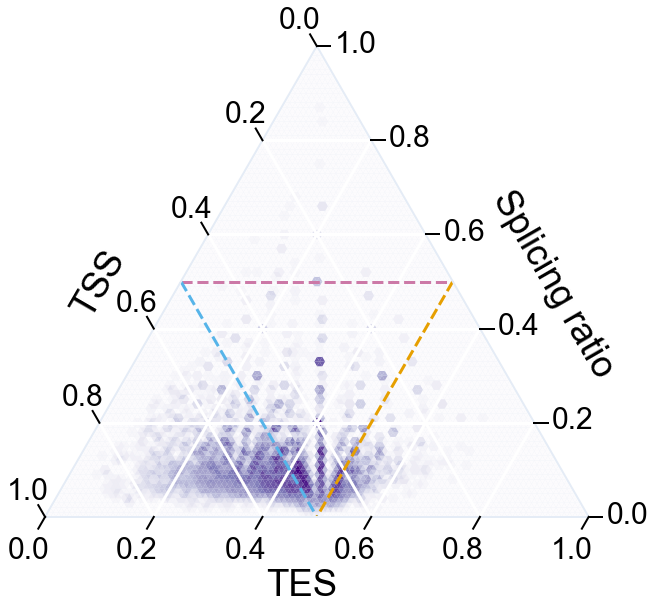

In [10]:
_ = ca.plot_simplex(density=True,
                    scatter=False,
                    subset={'source': ['talon']},
                    density_cmap='Purples', 
                    log_density=True,
                    sectors=True,
                    density_scale=100)

In [4]:
df = pr.read_gtf(fname, duplicate_attr=True)

In [5]:
g_df = df.as_df()[[gene_id_col, gene_name_col]].drop_duplicates()
g_df.rename({gene_id_col:'gene_id', gene_name_col:'gene_name'}, axis=1, inplace=True)

In [6]:
# get triplet features from the gtf
tss = df.features.tss().as_df()
tes = df.features.tes().as_df()
ic = cerberus.get_ic(df)

m = {gene_id_col:'gene_id', 
     gene_name_col:'gene_name'}
tss.rename(m, axis=1, inplace=True)
tes.rename(m, axis=1, inplace=True)
ic.rename(m, axis=1, inplace=True)

In [7]:
# limit to just the unique triplet features per gene
tss = tss[['gene_id', 'Start']].drop_duplicates()
tes = tes[['gene_id', 'Start']].drop_duplicates()
ic = ic[['gene_id', 'ic']].drop_duplicates()

# rename stuff 
tss.rename({'Start':'Name'}, axis=1, inplace=True)
tes.rename({'Start':'Name'}, axis=1, inplace=True)
ic.rename({'ic':'Name'}, axis=1, inplace=True)

In [8]:
tss_back = tss.copy(deep=True)
tes_back = tes.copy(deep=True)
ic_back = ic.copy(deep=True)

In [9]:
print(len(tss_back.gene_id.unique()))
print(len(tss_back.index))

47219
142785


In [10]:
# get counts for each thing
tss = cerberus.count_instances(tss, 'tss')
tes = cerberus.count_instances(tes, 'tes')
ic = cerberus.count_instances(ic, 'ic')

In [11]:
# create a table 
trip_df = tss.merge(tes, how='outer', on='gene_id')
trip_df = trip_df.merge(ic, how='outer', on='gene_id')
trip_df['source'] = source
trip_df.head()

,gene_id,n_tss,n_tes,n_ic,source
0,ENCODEHG000058781,1,1,1,talon
1,ENCODEHG000058782,1,1,1,talon
2,ENCODEHG000058784,3,3,6,talon
3,ENCODEHG000058785,1,1,1,talon
4,ENCODEHG000058786,1,1,1,talon


In [12]:
# add splicing ratio and compute simplex coords
trip_df = cerberus.compute_splicing_ratio(trip_df)
trip_df = cerberus.compute_simplex_coords(trip_df)
trip_df = cerberus.assign_sector(trip_df)

In [13]:
# rename gid col
trip_df.rename({'gene_id': 'gid'}, axis=1, inplace=True)

In [14]:
# add gene name
if gene_name_col:
    trip_df = trip_df.merge(g_df[['gene_id', 'gene_name']], how='left', left_on='gid', right_on='gene_id')
    trip_df.drop('gene_id', axis=1, inplace=True)
    trip_df.rename({'gene_name': 'gname'}, axis=1, inplace=True)

In [15]:
# shove this into a cerberus annotation to make sure it works with triplet plotting stuff
ca = cerberus.CerberusAnnotation()
ca.add_triplets(trip_df, source='talon')

In [16]:
ca.triplets.head()

,gid,n_tss,n_tes,n_ic,source,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname
0,ENCODEHG000058781,1,1,1,talon,1.0,0.333333,0.333333,0.333333,simple,ENCODEHG000058781
1,ENCODEHG000058782,1,1,1,talon,1.0,0.333333,0.333333,0.333333,simple,ENCODEHG000058782
2,ENCODEHG000058784,3,3,6,talon,2.0,0.375000,0.375000,0.250000,mixed,ENCODEHG000058784
3,ENCODEHG000058785,1,1,1,talon,1.0,0.333333,0.333333,0.333333,simple,ENCODEHG000058785
4,ENCODEHG000058786,1,1,1,talon,1.0,0.333333,0.333333,0.333333,simple,ENCODEHG000058786


In [17]:
ca.write('test_triplets.h5')

In [3]:
ca = cerberus.read('test_triplets.h5')

In [5]:
ca.triplets.loc[ca.triplets.gname=='ELN']

,gid,n_tss,n_tes,n_ic,source,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname
13545,ENSG00000049540.16,52,12,234,talon,7.3125,0.729185,0.168273,0.102542,tss,ELN


,gid,n_tss,n_tes,n_ic,source,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname
13545,ENSG00000049540.16,52,12,234,talon,7.3125,0.729185,0.168273,0.102542,tss,ELN


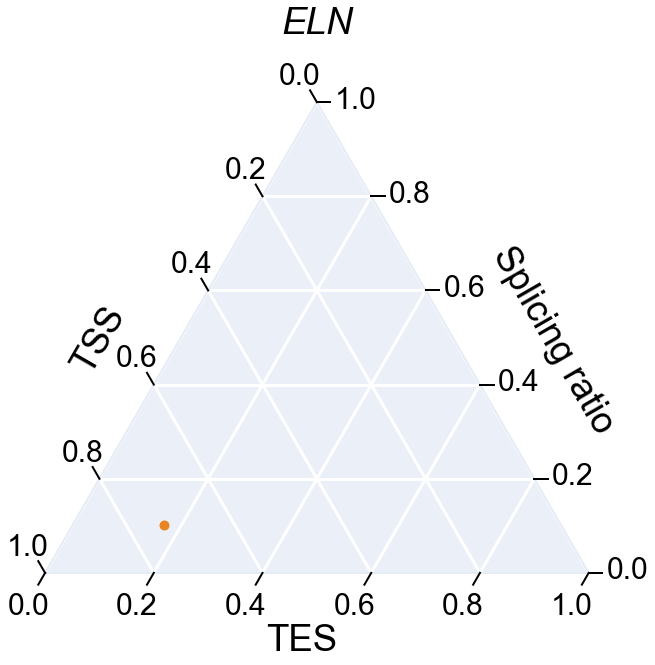

In [4]:
ca.plot_simplex(gene='ELN', scatter=True)

In [10]:
gtf = 'tests/files/Canx.gtf'
dist = 50

gr_gtf = pr.read_gtf(gtf)

df_tss = gr_gtf.features.tss()#.extend(dist)

In [11]:
df_tss.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_status,transcript_name,protein_id,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript
0,chr11,ENSEMBL,tss,50325672,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,NaN,NaN,NaN
1,chr11,HAVANA,tss,50325672,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-001,ENSMUSP00000020637.8,CCDS,1,CCDS24633.1,NaN,NaN,OTTMUST00000012410.1
2,chr11,HAVANA,tss,50299377,50299378,.,-,.,ENSMUSG00000020368.14,protein_coding,...,processed_transcript,KNOWN,Canx-003,NaN,NaN,2,NaN,NaN,NaN,OTTMUST00000012412.1
3,chr11,HAVANA,tss,50298318,50298319,.,-,.,ENSMUSG00000020368.14,protein_coding,...,processed_transcript,KNOWN,Canx-002,NaN,NaN,5,NaN,NaN,NaN,OTTMUST00000012411.1
4,chr11,HAVANA,tss,50300989,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,processed_transcript,KNOWN,Canx-004,NaN,NaN,3,NaN,NaN,NaN,OTTMUST00000012413.1


In [ ]:
d = {'Chromosome': ['chr1', 'chr1', 'chr1'], 'Start': [3, 8, 5], 'End': [6, 9, 7],
     'Strand': ['+', '+', '-']}
gr = pr.from_dict(d)
gr

In [15]:
tss_bed = 'tests/files/Canx_tss.bed'
tes_bed = 'tests/files/Canx_tes.bed'
gtf = 'tests/files/Canx.gtf'

In [16]:
gtf = pr.read_gtf(gtf, duplicate_attr=True)

In [17]:
gtf.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_status,transcript_name,protein_id,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript
0,chr11,HAVANA,gene,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr11,ENSEMBL,transcript,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,NaN,NaN,NaN
2,chr11,ENSEMBL,exon,50325492,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,1,ENSMUSE00000371309.6,NaN
3,chr11,ENSEMBL,exon,50311603,50311780,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
4,chr11,ENSEMBL,CDS,50311603,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
5,chr11,ENSEMBL,start_codon,50311774,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
6,chr11,ENSEMBL,exon,50310793,50310867,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN
7,chr11,ENSEMBL,CDS,50310793,50310867,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN


In [18]:
gtf = gtf.df

In [19]:
gtf = gtf.loc[gtf.Feature == 'transcript']


In [20]:
gtf.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_status,transcript_name,protein_id,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript
1,chr11,ENSEMBL,transcript,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,NaN,NaN,NaN
36,chr11,HAVANA,transcript,50294466,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-001,ENSMUSP00000020637.8,"basic,appris_principal_1,CCDS",1,CCDS24633.1,NaN,NaN,OTTMUST00000012410.1
71,chr11,HAVANA,transcript,50296198,50299378,.,-,.,ENSMUSG00000020368.14,protein_coding,...,processed_transcript,KNOWN,Canx-003,NaN,NaN,2,NaN,NaN,NaN,OTTMUST00000012412.1
77,chr11,HAVANA,transcript,50297363,50298319,.,-,.,ENSMUSG00000020368.14,protein_coding,...,processed_transcript,KNOWN,Canx-002,NaN,NaN,5,NaN,NaN,NaN,OTTMUST00000012411.1
80,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,processed_transcript,KNOWN,Canx-004,NaN,NaN,3,NaN,NaN,NaN,OTTMUST00000012413.1


In [21]:
gtf['basic_set'] = gtf.tag.str.contains('basic')

In [53]:
gtf['temp'] = gtf.tag.str.split('appris_principal_', n=1, expand=True)[1]
gtf['appris_principal'] = gtf.temp.str.split(',', n=1, expand=True)[0]

In [54]:
gtf.basic_set.fillna(False, inplace=True)
gtf = gtf.sort_values(by=['appris_principal', 'basic_set'], 
                      ascending=[False, True],
                      na_position='last')

In [55]:

gtf

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,protein_id,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,basic_set,temp,appris_principal
1,chr11,ENSEMBL,transcript,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,NaN,NaN,NaN,True,"1,CCDS",1
36,chr11,HAVANA,transcript,50294466,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,ENSMUSP00000020637.8,"basic,appris_principal_1,CCDS",1,CCDS24633.1,NaN,NaN,OTTMUST00000012410.1,True,"1,CCDS",1
71,chr11,HAVANA,transcript,50296198,50299378,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,NaN,2,NaN,NaN,NaN,OTTMUST00000012412.1,False,NaN,NaN
77,chr11,HAVANA,transcript,50297363,50298319,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,NaN,5,NaN,NaN,NaN,OTTMUST00000012411.1,False,NaN,NaN
80,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,NaN,3,NaN,NaN,NaN,OTTMUST00000012413.1,False,NaN,NaN


## compute triplets

In [310]:
def get_transcript_ref(fname):
    
    df = pr.read_gtf(fname, duplicate_attr=True).df
    df = df.loc[df.Feature == 'transcript']
    df['basic_set'] = df.tag.str.contains('basic')
    df['temp'] = df.tag.str.split('appris_principal_', n=1, expand=True)[1]
    df['appris_principal'] = df.temp.str.split(',', n=1, expand=True)[0]
    
    return df

In [311]:
def number_tss_ic_tes(df, mode):
    # groupby feature but record which feature
    # each transcript id uses 
    cols = ['transcript_id', mode, 'basic_set', 'appris_principal', 'gene_id']
    df = df[cols].groupby([mode, 'gene_id']).agg({'transcript_id': ','.join,
                                     'basic_set': 'max',
                                     'appris_principal': 'min'}).reset_index()

    # compute intron chain number
    df['{}_num'.format(mode)] = df.sort_values(by=['gene_id', 'appris_principal', 'basic_set'],
                                 ascending=[True, False, True],
                                 na_position='last')\
                                 .groupby(['gene_id'])\
                                 .cumcount() + 1
    
    return df

In [312]:
gtf = 'tests/files/Canx.gtf'
tss_bed = 'tests/files/Canx_tss.bed'
tes_bed = 'tests/files/Canx_tes.bed'

In [351]:
### intron chain annotation ###

# get basic status and appris_principal tag for each transcript
t_df = get_transcript_ref(fname)
t_df = t_df[['transcript_id', 'gene_id', 'basic_set', 'appris_principal']]

# get unique intron chains from gtf
df = pr.read_gtf(fname).df

# restrict to exon entries
df = df.loc[df.Feature == 'exon']
cols = ['Chromosome', 'Strand', 'Start', 'End', 'transcript_id', 'gene_id']
df = df[cols]

# melt to isolate individual coordinates
df = pd.melt(df, id_vars=['Chromosome', 'Strand', 'transcript_id', 'gene_id'],
            value_vars=['Start', 'End'],
            value_name='Coord')
df.drop('variable', axis=1, inplace=True)

# sort to order coordinates correctly
df.Coord = df.Coord.astype(int)
fwd = df.loc[df.Strand == '+'].copy(deep=True)
rev = df.loc[df.Strand == '-'].copy(deep=True)

fwd.sort_values(by=['Chromosome', 'transcript_id', 'Coord'],
                ascending=[True, True, True])
rev.sort_values(by=['Chromosome', 'transcript_id', 'Coord'],
                ascending=[True, True, False])
df = pd.concat([fwd, rev])

# create intron chain strings
df.Coord = df.Coord.astype(str)
df = df.groupby(['Chromosome', 'Strand', 'transcript_id'])['Coord'].apply('-'.join).reset_index()

# remove tss and tes from intron chain
df['temp'] = df.Coord.str.split('-', n=1, expand=True)[1]
df['ic'] = df.temp.str.rsplit('-', n=1, expand=True)[0]

# add basic annotation, appris principal number, and gene id
df = df.merge(t_df, on='transcript_id', how='left')

# add number for each unique intron chain
df = number_tss_ic_tes(df, mode='ic')

# keep track of which transcripts use each intron chain
df.transcript_id = df.transcript_id.str.split(',')
ttrip_df = df[['transcript_id', 'ic_num']].explode(column='transcript_id')

In [352]:
### tss / tes numbering ###
beds = {}
for mode, bed_file in zip(['tss', 'tes'], [tss_bed, tes_bed]):

    ends = pr.read_bed(bed_file).df
    ends.rename({'ThickStart': 'gene_id'}, axis=1, inplace=True)
    ends[mode] = [i for i in range(len(ends.index))]
    ends = pr.PyRanges(ends)

    # merge gtf ends with bed ends
    df = pr.read_gtf(gtf)
    if mode == 'tss':
        df = df.features.tss().df
    elif mode == 'tes':
        df = df.features.tes().df

    # merge in information about transcript status
    t_df = get_transcript_ref(gtf)
    t_df = t_df[['transcript_id', 'appris_principal', 'basic_set']]
    df = df.merge(t_df, how='left', on='transcript_id')
    df = pr.PyRanges(df)

    # join with bed ends
    df = df.join(ends, 
                 strandedness='same',
                 how='left').df
    df = df.loc[df.gene_id == df.gene_id_b]

    # add number for each unique end region
    df = number_tss_ic_tes(df, mode=mode)
    
    # keep track of which transcripts use each intron chain
    df.transcript_id = df.transcript_id.str.split(',')
    temp = df[['transcript_id', '{}_num'.format(mode)]].explode(column='transcript_id')  
    ttrip_df = ttrip_df.merge(temp, on='transcript_id')   
    
    # add numbers back into bed file
    ends = ends.df
    ends = ends.merge(df[[mode, '{}_num'.format(mode)]], on=mode)
    
    ends['Name'] = ends.gene_id+'_'+ends['{}_num'.format(mode)].astype(str)
    ends.drop([mode, 'gene_id', '{}_num'.format(mode)], axis=1, inplace=True)
    beds[mode] = pr.PyRanges(ends)

In [353]:
# create formatted string to represent each transcript
ttrip_df['transcript_triplet'] = '['+ttrip_df['tss_num'].astype(str)+', '+\
                                     ttrip_df['ic_num'].astype(str)+', '+\
                                     ttrip_df['tes_num'].astype(str)+']'

In [354]:
ttrip_df

,transcript_id,ic_num,tss_num,tes_num,transcript_triplet
0,ENSMUST00000153068.1,4,4,5,"[4, 4, 5]"
1,ENSMUST00000146979.1,5,3,4,"[3, 5, 4]"
2,ENSMUST00000155801.1,1,2,3,"[2, 1, 3]"
3,ENSMUST00000155801.2,1,2,3,"[2, 1, 3]"
4,ENSMUST00000179865.6,2,1,1,"[1, 2, 1]"
5,ENSMUST00000020637.8,3,1,2,"[1, 3, 2]"


In [355]:
### output files ###

# gtf
df = pr.read_gtf(gtf, duplicate_attr=True).df
df = df.merge(ttrip_df[['transcript_id', 'transcript_triplet']], 
              how='left',
              on='transcript_id')
df = pr.PyRanges(df)

In [356]:
beds['tss']

,Chromosome,Start,End,Name,Score,Strand
0,chr11,50325622,50325723,ENSMUSG00000020368.14_1,.,-
1,chr11,50299327,50299428,ENSMUSG00000020368.14_3,.,-
2,chr11,50298268,50298369,ENSMUSG00000020368.14_4,.,-
3,chr11,50300939,50301040,ENSMUSG00000020368.14_2,.,-


In [338]:
df.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,protein_id,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_triplet
0,chr11,HAVANA,gene,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr11,ENSEMBL,transcript,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,NaN,NaN,NaN,"[1, 2, 1]"
2,chr11,ENSEMBL,exon,50325492,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,1,ENSMUSE00000371309.6,NaN,"[1, 2, 1]"
3,chr11,ENSEMBL,exon,50311603,50311780,.,-,.,ENSMUSG00000020368.14,protein_coding,...,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN,"[1, 2, 1]"
4,chr11,ENSEMBL,CDS,50311603,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN,"[1, 2, 1]"
5,chr11,ENSEMBL,start_codon,50311774,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN,"[1, 2, 1]"
6,chr11,ENSEMBL,exon,50310793,50310867,.,-,.,ENSMUSG00000020368.14,protein_coding,...,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN,"[1, 2, 1]"
7,chr11,ENSEMBL,CDS,50310793,50310867,.,-,0,ENSMUSG00000020368.14,protein_coding,...,KNOWN,Canx-201,ENSMUSP00000137440.1,"basic,appris_principal_1,CCDS",1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN,"[1, 2, 1]"


,ic,gene_id,transcript_id,basic_set,appris_principal
0,50297363-50298319,ENSMUSG00000020368.14,ENSMUST00000153068.1,NaN,NaN
1,50298116-50297273-50297057-50296198-50299378-5...,ENSMUSG00000020368.14,ENSMUST00000146979.1,NaN,NaN
2,50298837-50300990,ENSMUSG00000020368.14,"ENSMUST00000155801.1,ENSMUST00000155801.2",True,1
3,50311603-50310793-50310371-50308787-50308309-5...,ENSMUSG00000020368.14,ENSMUST00000179865.6,True,1
4,50311603-50310793-50310371-50308787-50308309-5...,ENSMUSG00000020368.14,ENSMUST00000020637.8,True,1


In [203]:
df.head()

,ic,gene_id,transcript_id,basic_set,appris_principal,ic_num
0,50297363-50298319,ENSMUSG00000020368.14,ENSMUST00000153068.1,NaN,NaN,4
1,50298116-50297273-50297057-50296198-50299378-5...,ENSMUSG00000020368.14,ENSMUST00000146979.1,NaN,NaN,5
2,50298837-50300990,ENSMUSG00000020368.14,"ENSMUST00000155801.1,ENSMUST00000155801.2",True,1,1
3,50311603-50310793-50310371-50308787-50308309-5...,ENSMUSG00000020368.14,ENSMUST00000179865.6,True,1,2
4,50311603-50310793-50310371-50308787-50308309-5...,ENSMUSG00000020368.14,ENSMUST00000020637.8,True,1,3


#### make canx abundance file for testing purposes


In [417]:
df = pd.read_csv('/Users/fairliereese/mortazavi_lab/data/mousewg/lr_bulk/talon/mouse_talon_abundance.tsv', sep='\t')

In [418]:
df = df.loc[df.annot_gene_name == 'Canx']
df = df.loc[df.transcript_novelty == 'Known']

In [419]:
# rename transcripts according to transcript names
gtf_df = pr.read_gtf('tests/files/Canx.gtf').df
gtf_df = gtf_df.loc[gtf_df.Feature == 'transcript']

In [420]:
gtf_df.transcript_id
gtf_df['tid_stable'] = gtf_df.transcript_id.str.split('.', n=1, expand=True)[0]

In [421]:
df['tid_stable'] = df.annot_transcript_id.str.split('.', n=1, expand=True)[0]

In [422]:
gtf_df = gtf_df[['tid_stable', 'transcript_id']]
df = df.merge(gtf_df, on='tid_stable')

In [423]:
df.annot_transcript_id = df.transcript_id
df.drop(['transcript_id', 'tid_stable'], axis=1, inplace=True)

In [424]:
df

,gene_ID,transcript_ID,annot_gene_id,annot_transcript_id,annot_gene_name,annot_transcript_name,n_exons,length,gene_novelty,transcript_novelty,...,gastroc_25d_m_2,gastroc_25d_m_1,gastroc_10d_f_2,gastroc_10d_f_1,gastroc_25d_f_1,gastroc_25d_f_2,gastroc_4d_m_1,gastroc_4d_m_2,gastroc_10d_m_1,gastroc_10d_m_2
0,32839,86107,ENSMUSG00000020368.15,ENSMUST00000179865.6,Canx,Canx-205,15,4281,Known,Known,...,1,0,0,3,0,1,4,2,0,0
1,32839,86108,ENSMUSG00000020368.15,ENSMUST00000020637.8,Canx,Canx-201,15,3779,Known,Known,...,12,44,26,67,38,35,104,96,60,34
2,32839,86109,ENSMUSG00000020368.15,ENSMUST00000146979.1,Canx,Canx-202,5,708,Known,Known,...,1,1,1,1,0,2,2,1,3,0
3,32839,86110,ENSMUSG00000020368.15,ENSMUST00000153068.1,Canx,Canx-203,2,234,Known,Known,...,0,0,0,0,0,0,0,0,0,0
4,32839,86111,ENSMUSG00000020368.15,ENSMUST00000155801.1,Canx,Canx-204,2,600,Known,Known,...,0,0,0,0,0,0,0,0,0,0
5,32839,86111,ENSMUSG00000020368.15,ENSMUST00000155801.2,Canx,Canx-204,2,600,Known,Known,...,0,0,0,0,0,0,0,0,0,0


In [395]:
df.to_csv('tests/files/Canx_abundance.tsv', sep='\t', index=False)"

#### Changing transcript IDs in TALON abundance file and optionally? aggregating counts

In [1]:
def get_nov_ranks():
    """
    Get rank for each novelty category
    
    Returns:
        nov_rank (dict): Dictionary of novelty category: int rank
        rank_nov (dict): Dictionary of int rank: novelty category
    """
    nov_rank = {'Known': 0,
           'NIC': 1,
           'ISM': 2,
           'NNC': 3,
           'Genomic': 4,
           'Antisense': 5,
           'Intergenic': 6}
    
    rank_nov = dict()
    for key, item in nov_rank.items():
        rank_nov[item] = key

    return nov_rank, rank_nov

def get_ism_ranks():
    """
    Get rank for each ISM subtype category 
    
    Returns:
        ism_rank (dict): Dictionary of ism subtype: int rank
        rank_ism (dict): Dictionary of int rank: ism subtype
    """
    ism_rank = {'Both': 0,
                'Prefix': 1,
                'Suffix': 2,
                None: 3}
    rank_ism = dict()
    for key, item in ism_rank.items():
        rank_ism[item] = key

    return ism_rank, rank_ism

def get_non_dataset_cols():
    """
    Get a list of ordered columns from TALON abundance file that
    are the non-dataset columns
    
    Returns:
        non_dataset_cols (list of str): List of non-dataset columns
    """
    non_dataset_cols = ['gene_ID', 'transcript_ID', 'annot_gene_id',
                   'annot_transcript_id', 'annot_gene_name',
                   'annot_transcript_name', 'n_exons', 'length',
                   'gene_novelty', 'transcript_novelty', 'ISM_subtype']
    return non_dataset_cols

def get_dataset_cols(df):
    """
    Get a list of the dataset columns from a TALON abundance file
    
    Parameters:
        df (pandas DataFrame): TALON abundance file
        
    Returns:
        dataset_cols (list of str): List of dataset columns
    """
    non_dataset_cols = get_non_dataset_cols()
    dataset_cols = [ x for x in list(df.columns) \
                        if x not in non_dataset_cols ]
    return dataset_cols

In [144]:
def replace_ab_ids(ab, m, agg):
    """
    Replace the transcript ids and transcript names in a TALON abundance file
    with the new transcript ids that contain the triplet
    
    Parameters:
        ab (str): Path to TALON abundance file
        m (str): Path to map file (output from assign_triplets)
        agg (bool): Aggregate / collapse transcripts with the same triplets
            and sum up their count values
        
    Returns:
        df (pandas DataFrame): TALON abundance file with updated
            transcript ids / names
    """
    df = pd.read_csv(ab, sep='\t')
    m_df = pd.read_csv(m, sep='\t')

    # fix transcript ids in abundance file
    ab_map = m_df[['original_transcript_id', 'original_transcript_name', 'transcript_name', 'transcript_id']]
    df = df.merge(ab_map, left_on='annot_transcript_id', right_on='original_transcript_id')

    df.drop(['original_transcript_id', 'original_transcript_name', 
             'annot_transcript_id', 'annot_transcript_name'],
            axis=1, inplace=True)
    df.rename({'transcript_name': 'annot_transcript_name',
               'transcript_id': 'annot_transcript_id'},
              axis=1, inplace=True)

    # aggregate counts if requested
    if agg:
        gb_cols = ['gene_ID', 'annot_gene_id', 'annot_gene_name',
                   'gene_novelty', 'annot_transcript_name',
                   'annot_transcript_id']

        # handle properties which won't always correspond across the transcripts
        # these are all subject to change
        nov_rank, rank_nov = get_nov_ranks()
        df['nov_rank'] = df.transcript_novelty.map(nov_rank)
        df.drop('transcript_novelty', axis=1, inplace=True)

        ism_rank, rank_ism = get_ism_ranks()
        df['ism_rank'] = df.ISM_subtype.map(ism_rank)
        df.drop('ISM_subtype', axis=1, inplace=True)

        df['transcript_ID'] = df.transcript_ID.astype(str)
        agg_dict = {'transcript_ID': ','.join,
                    'n_exons': 'mean', 
                    'length': 'mean',
                    'nov_rank': 'min',
                    'ism_rank': 'min'}
        cols = gb_cols + list(agg_dict.keys())
        for c in list(set(df.columns)-set(cols)):
            agg_dict[c] = 'sum'

        df = df.groupby(gb_cols).agg(agg_dict).reset_index()
        df['transcript_novelty'] = df.nov_rank.map(rank_nov)
        df.drop(['nov_rank'], axis=1, inplace=True)
        df['ISM_subtype'] = df.ism_rank.map(rank_ism)
        df.drop(['ism_rank'], axis=1, inplace=True)

    # reorder columns
    c1 = get_non_dataset_cols()
    c2 = get_dataset_cols(df)
    df = df[c1+c2]
    
    return df

In [145]:
def replace_gtf_ids(gtf, m, agg):
    """
    Replace transcript ids and names in a gtf with the triplets
    calculated from assign_triplets
    
    Parameters:
        gtf (str): Path to gtf file
        m (str): Path to map file output from assign_triplets
        agg (bool): Whether or not to collapse transcripts with
            duplicate triplets
            
    Returns:
        df (pyranges PyRanges): PyRanges gtf table with updated ids
    """
    
    df = pr.read_gtf(gtf).df
    m_df = pd.read_csv(m, sep='\t')

    # groupby transcripts that are the same
    gb_cols = ['gene_name', 'gene_id', 'transcript_triplet',
               'transcript_id', 'transcript_name']
    temp = m_df[['transcript_id',
                 'original_transcript_id',
                 'original_transcript_name']].copy(deep=True)
    m_df = m_df.groupby(gb_cols).agg({'original_transcript_id': ','.join,
                                      'original_transcript_name': ','.join}).reset_index()
    m_df = m_df.merge(temp, on='transcript_id', suffixes=('','_merge'))
    m_df.drop(['gene_name', 'gene_id', 'transcript_triplet'],
              axis=1, inplace=True)

    # add new transcript ids 
    df = df.merge(m_df, left_on=['transcript_id', 'transcript_name'],
                  right_on=['original_transcript_id_merge',
                            'original_transcript_name_merge'],
                 suffixes=('_x', ''))

    # drop old tids
    df.drop(['transcript_id_x', 'transcript_name_x',
             'original_transcript_name_merge'],
            axis=1, inplace=True)

    # remove duplicated transcripts; just keeping the first one
    if agg:
        temp = df[['transcript_id', 'original_transcript_id_merge']].drop_duplicates()
        dupe_old_tids = temp.loc[temp.transcript_id.duplicated(keep='first'), 'original_transcript_id_merge']
        df = df.loc[~df.original_transcript_id_merge.isin(dupe_old_tids)]  

    # drop last column
    df.drop('original_transcript_id_merge', axis=1, inplace=True)

    df = pr.PyRanges(df)
    
    return df

In [148]:
ab = 'tests/files/Canx_abundance.tsv'
gtf = 'tests/files/Canx.gtf'
m = 'tests/files/Canx_triplet_tid_map.tsv'
h5 = '' # option to use / save in previous step as h5df?

beep =  replace_ab_ids(ab, m, True)
beep2 = replace_gtf_ids(gtf, m, True)

In [150]:
beep

,gene_ID,transcript_ID,annot_gene_id,annot_transcript_id,annot_gene_name,annot_transcript_name,n_exons,length,gene_novelty,transcript_novelty,ISM_subtype,adrenal_2mo_f_1
0,32839,86107,ENSMUSG00000020368.15,"ENSMUSG00000020368.14 [1, 2, 1]",Canx,"Canx [1, 2, 1]",15,4281,Known,Known,Prefix,8
1,32839,86108,ENSMUSG00000020368.15,"ENSMUSG00000020368.14 [1, 3, 2]",Canx,"Canx [1, 3, 2]",15,3779,Known,Known,NaN,371
2,32839,"86111,86111",ENSMUSG00000020368.15,"ENSMUSG00000020368.14 [2, 1, 3]",Canx,"Canx [2, 1, 3]",2,600,Known,Known,NaN,2
3,32839,86109,ENSMUSG00000020368.15,"ENSMUSG00000020368.14 [3, 5, 4]",Canx,"Canx [3, 5, 4]",5,708,Known,Known,NaN,1
4,32839,86110,ENSMUSG00000020368.15,"ENSMUSG00000020368.14 [4, 4, 5]",Canx,"Canx [4, 4, 5]",2,234,Known,Known,NaN,0


In [158]:
ab = 'tests/files/Canx_abundance.tsv'
gtf = 'tests/files/Canx.gtf'
m = 'tests/files/Canx_triplet_tid_map.tsv'
h5 = '' # option to use / save in previous step as h5df?

agg = True


df = pd.read_csv(ab, sep='\t')
m_df = pd.read_csv(m, sep='\t')

# fix transcript ids in abundance file
ab_map = m_df[['original_transcript_id', 'original_transcript_name', 'transcript_name', 'transcript_id']]
df = df.merge(ab_map, left_on='annot_transcript_id', right_on='original_transcript_id')

df.drop(['original_transcript_id', 'original_transcript_name', 
         'annot_transcript_id', 'annot_transcript_name'],
        axis=1, inplace=True)
df.rename({'transcript_name': 'annot_transcript_name',
           'transcript_id': 'annot_transcript_id'},
          axis=1, inplace=True)

# aggregate counts if requested
if agg:
    gb_cols = ['gene_ID', 'annot_gene_id', 'annot_gene_name',
               'gene_novelty', 'annot_transcript_name',
               'annot_transcript_id']
    
    # handle properties which won't always correspond across the transcripts
    # these are all subject to change
    nov_rank, rank_nov = get_nov_ranks()
    df['nov_rank'] = df.transcript_novelty.map(nov_rank)
    df.drop('transcript_novelty', axis=1, inplace=True)
    
    ism_rank, rank_ism = get_ism_ranks()
    df['ism_rank'] = df.ISM_subtype.map(ism_rank)
    df.drop('ISM_subtype', axis=1, inplace=True)
    
    df['transcript_ID'] = df.transcript_ID.astype(str)
    agg_dict = {'transcript_ID': ','.join,
                'n_exons': 'mean', 
                'length': 'mean',
                'nov_rank': 'min',
                'ism_rank': 'min'}
    cols = gb_cols + list(agg_dict.keys())
    for c in list(set(df.columns)-set(cols)):
        agg_dict[c] = 'sum'
    
    df = df.groupby(gb_cols).agg(agg_dict).reset_index()
    df['transcript_novelty'] = df.nov_rank.map(rank_nov)
    df.drop(['nov_rank'], axis=1, inplace=True)
    df['ISM_subtype'] = df.ism_rank.map(rank_ism)
    df.drop(['ism_rank'], axis=1, inplace=True)
    
# reorder columns
c1 = get_non_dataset_cols()
c2 = get_dataset_cols(df)
df = df[c1+c2]

In [166]:
df = pr.read_gtf(gtf).df
m_df = pd.read_csv(m, sep='\t')

# groupby transcripts that are the same
gb_cols = ['gene_name', 'gene_id', 'transcript_triplet',
           'transcript_id', 'transcript_name']
temp = m_df[['transcript_id',
             'original_transcript_id',
             'original_transcript_name']].copy(deep=True)
m_df = m_df.groupby(gb_cols).agg({'original_transcript_id': ','.join,
                                  'original_transcript_name': ','.join}).reset_index()
m_df = m_df.merge(temp, on='transcript_id', suffixes=('','_merge'))
m_df.drop(['gene_name', 'gene_id', 'transcript_triplet'],
          axis=1, inplace=True)

# add new transcript ids 
df = df.merge(m_df, left_on=['transcript_id', 'transcript_name'],
              right_on=['original_transcript_id_merge',
                        'original_transcript_name_merge'],
             suffixes=('_x', ''))

# drop old tids
df.drop(['transcript_id_x', 'transcript_name_x',
         'original_transcript_name_merge'],
        axis=1, inplace=True)

# remove duplicated transcripts; just keeping the first one
if agg:
    temp = df[['transcript_id', 'original_transcript_id_merge']].drop_duplicates()
    dupe_old_tids = temp.loc[temp.transcript_id.duplicated(keep='first'), 'original_transcript_id_merge']
    print(df.loc[df.transcript_id == 'ENSMUSG00000020368.14 [2, 1, 3]', ['Feature', 'transcript_id', 'original_transcript_id_merge']])
    df = df.loc[~df.original_transcript_id_merge.isin(dupe_old_tids)]
    print(df.loc[df.transcript_id == 'ENSMUSG00000020368.14 [2, 1, 3]', ['Feature', 'transcript_id', 'original_transcript_id_merge']])

# drop last column
df.drop('original_transcript_id_merge', axis=1, inplace=True)

       Feature                    transcript_id original_transcript_id_merge
79  transcript  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1
80        exon  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1
81         CDS  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1
82        exon  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1
83         CDS  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1
84  transcript  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.2
85        exon  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.2
86        exon  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.2
       Feature                    transcript_id original_transcript_id_merge
79  transcript  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1
80        exon  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1
81         CDS  ENSMUSG00000020368.14 [2, 1, 3]         ENSMUST00000155801.1

In [141]:
temp.loc[temp.transcript_id == 'ENSMUSG00000020368.14 [2, 1, 3]']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_id,transcript_name,original_transcript_id,original_transcript_name,original_transcript_id_merge
79,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
80,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
81,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
82,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
83,chr11,HAVANA,CDS,50300896,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1


In [124]:
# get the start and stop coords for transcripts that are duplicated
temp = df.loc[df.Feature == 'transcript'].copy(deep=True)
df.head()
cols = ['Start', 'End',
        'transcript_id', 'Strand']
temp = temp[cols].melt(id_vars=['transcript_id', 'Strand'], 
                       value_vars=['Start', 'End'],
                       value_name='coord')
temp.drop('variable', axis=1, inplace=True)
rev_temp = temp.loc[temp.Strand == '-']
fwd_temp = temp.loc[temp.Strand == '+']

for strand, t_df in zip(['+', '-'], [fwd_temp, rev_temp]):
    
    # get min and max coords for each transcript
    temp = t_df.copy(deep=True)
    temp = temp.groupby('transcript_id').agg({'coord': ['min', 'max']})
    temp = temp.droplevel(level=0, axis=1)
    temp.reset_index(inplace=True)
    
    # these will be the new start / end coordinates for transcripts
    # and their first exons (and possibly CDSs/UTRs/etc)
    # if strand == '+':
    d = {'min': 'new_Start', 'max': 'new_End'}
    # elif strand == '-':
    #     d = {'min': 'new_End', 'max': 'new_Start'}
    
    temp.rename(d, axis=1, inplace=True)
    new_ends = temp.copy(deep=True)
    
    # get starts / ends from each transcript
    
    

In [125]:
new_ends.head()
# t_df.head()

,transcript_id,new_Start,new_End
0,"ENSMUSG00000020368.14 [1, 2, 1]",50293960,50325673
1,"ENSMUSG00000020368.14 [1, 3, 2]",50294466,50325673
2,"ENSMUSG00000020368.14 [2, 1, 3]",50298836,50300990
3,"ENSMUSG00000020368.14 [3, 5, 4]",50296198,50299378
4,"ENSMUSG00000020368.14 [4, 4, 5]",50297363,50298319


In [126]:
# temp = df.merge(new_ends, how='left', on='transcript_id')

In [127]:
# temp.loc[temp.transcript_id == 'ENSMUSG00000020368.14 [2, 1, 3]', ['transcript_id', 'Start', 'End', 'new_Start', 'new_End']]

In [128]:
# temp['adj_Start'] 

In [131]:
# get list of all start / end coords for each transcript
temp = df.loc[df.Feature == 'transcript'].copy(deep=True)
df.head()
cols = ['Start', 'End',
        'transcript_id', 'Strand']
temp = temp[cols]

fwd_temp = temp.loc[temp.Strand == '+'].copy(deep=True)
rev_temp = temp.loc[temp.Strand == '-'].copy(deep=True)

for strand, t_df in zip(['+', '-'], [fwd_temp, rev_temp]):
    if strand == '+':
        t_df['old_Start'] = t_df[['Start', 'End']].min(axis=1)
        t_df['old_End'] = t_df[['Start', 'End']].max(axis=1)
    elif strand == '-':
        t_df['old_Start'] = t_df[['Start', 'End']].max(axis=1)
        t_df['old_End'] = t_df[['Start', 'End']].min(axis=1)
    t_df.drop(['Start', 'End'], axis=1, inplace=True)
    t_df.drop('Strand', axis=1, inplace=True)
    

    
    
    
    

In [133]:
df.loc[df.transcript_id == 'ENSMUSG00000020368.14 [2, 1, 3]']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_id,transcript_name,original_transcript_id,original_transcript_name,original_transcript_id_merge
79,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
80,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
81,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
82,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
83,chr11,HAVANA,CDS,50300896,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.1
84,chr11,HAVANA,transcript,50298836,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.2
85,chr11,HAVANA,exon,50300896,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.2
86,chr11,HAVANA,exon,50298836,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004",ENSMUST00000155801.2


In [95]:
df.tail(10)


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_id,transcript_name,original_transcript_id,original_transcript_name
77,chr11,HAVANA,exon,50298116,50298319,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,5,NaN,1,ENSMUSE00000825549.1,OTTMUST00000012411.1,"ENSMUSG00000020368.14 [4, 4, 5]","Canx [4, 4, 5]",ENSMUST00000153068.1,Canx-002
78,chr11,HAVANA,exon,50297363,50297394,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,5,NaN,2,ENSMUSE00000778008.1,OTTMUST00000012411.1,"ENSMUSG00000020368.14 [4, 4, 5]","Canx [4, 4, 5]",ENSMUST00000153068.1,Canx-002
79,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
80,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
81,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
82,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
83,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
84,chr11,HAVANA,transcript,50298836,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
85,chr11,HAVANA,exon,50300896,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
86,chr11,HAVANA,exon,50298836,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"


In [59]:
# temp['min'].head()

In [14]:
df.tail(10)

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_id,transcript_name,original_transcript_id,original_transcript_name
77,chr11,HAVANA,exon,50298116,50298319,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,5,NaN,1,ENSMUSE00000825549.1,OTTMUST00000012411.1,"ENSMUSG00000020368.14 [4, 4, 5]","Canx [4, 4, 5]",ENSMUST00000153068.1,Canx-002
78,chr11,HAVANA,exon,50297363,50297394,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,5,NaN,2,ENSMUSE00000778008.1,OTTMUST00000012411.1,"ENSMUSG00000020368.14 [4, 4, 5]","Canx [4, 4, 5]",ENSMUST00000153068.1,Canx-002
79,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
80,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
81,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
82,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
83,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
84,chr11,HAVANA,transcript,50298836,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
85,chr11,HAVANA,exon,50300896,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
86,chr11,HAVANA,exon,50298836,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"


In [639]:
# if we're only reporting one transcript per triplet
if agg:
    print(len(df.index))
    df = df.loc[~(df.duplicated(subset=['transcript_id',
                                         'transcript_name',
                                         'exon_id',
                                         'Feature'], keep='first'))]
    print(len(df.index))
    
# drop original_tid_merge

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_id,transcript_name,original_transcript_id,original_transcript_name
73,chr11,HAVANA,exon,50297273,50297394,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,2,NaN,3,ENSMUSE00001293345.1,OTTMUST00000012412.1,"ENSMUSG00000020368.14 [3, 5, 4]","Canx [3, 5, 4]",ENSMUST00000146979.1,Canx-003
74,chr11,HAVANA,exon,50297057,50297137,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,2,NaN,4,ENSMUSE00001310416.1,OTTMUST00000012412.1,"ENSMUSG00000020368.14 [3, 5, 4]","Canx [3, 5, 4]",ENSMUST00000146979.1,Canx-003
75,chr11,HAVANA,exon,50296198,50296335,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,2,NaN,5,ENSMUSE00000827057.1,OTTMUST00000012412.1,"ENSMUSG00000020368.14 [3, 5, 4]","Canx [3, 5, 4]",ENSMUST00000146979.1,Canx-003
76,chr11,HAVANA,transcript,50297363,50298319,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,5,NaN,NaN,NaN,OTTMUST00000012411.1,"ENSMUSG00000020368.14 [4, 4, 5]","Canx [4, 4, 5]",ENSMUST00000153068.1,Canx-002
77,chr11,HAVANA,exon,50298116,50298319,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,5,NaN,1,ENSMUSE00000825549.1,OTTMUST00000012411.1,"ENSMUSG00000020368.14 [4, 4, 5]","Canx [4, 4, 5]",ENSMUST00000153068.1,Canx-002
78,chr11,HAVANA,exon,50297363,50297394,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,5,NaN,2,ENSMUSE00000778008.1,OTTMUST00000012411.1,"ENSMUSG00000020368.14 [4, 4, 5]","Canx [4, 4, 5]",ENSMUST00000153068.1,Canx-002
79,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
80,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
81,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
82,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [2, 1, 3]","Canx [2, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"


In [624]:
# is the deduplication really working correctly? What happens to duplicated cds / other features?
df = pr.read_gtf('tests/files/Canx.gtf').df

In [625]:
df.Feature.unique()

['gene', 'transcript', 'exon', 'CDS', 'start_codon', 'stop_codon', 'UTR']
Categories (7, object): ['gene', 'transcript', 'exon', 'CDS', 'start_codon', 'stop_codon', 'UTR']

In [628]:
df.loc[df.transcript_name == 'Canx-201']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_status,transcript_name,protein_id,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript
1,chr11,ENSEMBL,transcript,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,NaN,NaN,NaN
2,chr11,ENSEMBL,exon,50325492,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,1,ENSMUSE00000371309.6,NaN
3,chr11,ENSEMBL,exon,50311603,50311780,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
4,chr11,ENSEMBL,CDS,50311603,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
5,chr11,ENSEMBL,start_codon,50311774,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
6,chr11,ENSEMBL,exon,50310793,50310867,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN
7,chr11,ENSEMBL,CDS,50310793,50310867,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN
8,chr11,ENSEMBL,exon,50310371,50310430,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,4,ENSMUSE00000103866.1,NaN
9,chr11,ENSEMBL,CDS,50310371,50310430,.,-,1,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,4,ENSMUSE00000103866.1,NaN
10,chr11,ENSEMBL,exon,50308787,50308929,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,5,ENSMUSE00000296570.1,NaN


In [630]:
df.head(10)

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_status,transcript_name,protein_id,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript
0,chr11,HAVANA,gene,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr11,ENSEMBL,transcript,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,NaN,NaN,NaN
2,chr11,ENSEMBL,exon,50325492,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,1,ENSMUSE00000371309.6,NaN
3,chr11,ENSEMBL,exon,50311603,50311780,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
4,chr11,ENSEMBL,CDS,50311603,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
5,chr11,ENSEMBL,start_codon,50311774,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN
6,chr11,ENSEMBL,exon,50310793,50310867,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN
7,chr11,ENSEMBL,CDS,50310793,50310867,.,-,0,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,3,ENSMUSE00000103860.1,NaN
8,chr11,ENSEMBL,exon,50310371,50310430,.,-,.,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,4,ENSMUSE00000103866.1,NaN
9,chr11,ENSEMBL,CDS,50310371,50310430,.,-,1,ENSMUSG00000020368.14,protein_coding,...,protein_coding,KNOWN,Canx-201,ENSMUSP00000137440.1,CCDS,1,CCDS24633.1,4,ENSMUSE00000103866.1,NaN


## change add_triplets to make it not return gtf and return IC reference


In [2]:
def get_transcript_ref(fname):
    """
    Get transcripts with necessary tags to order based on basic set etc.

    Parameters:
        fname (str): Path to GTF file

    Returns:
        df (pandas DataFrame): DataFrame of only transcript entries
            with tags parsed out
    """
    df = pr.read_gtf(fname, duplicate_attr=True).df
    df = df.loc[df.Feature == 'transcript']
    df['basic_set'] = df.tag.str.contains('basic')
    df['temp'] = df.tag.str.split('appris_principal_', n=1, expand=True)[1]
    df['appris_principal'] = df.temp.str.split(',', n=1, expand=True)[0]

    return df

def number_tss_ic_tes(df, mode):
    """
    Assign a number to each tss, intron chain, or tes per gene based on the
    status of the transcript

    Parameters:
        df (pandas DataFrame): DataFrame derived from PyRanges
            with gene id, tss/ic/tes id, and tags to order transcripts
            with
        mode (str): {'tss', 'ic', 'tes'}

    Returns:
        df (pandas DataFrame): DataFrame with an identifier for each unique
            tss/ic/tes per gene
    """
    # groupby feature but record which feature
    # each transcript id uses
    cols = ['transcript_id', 'Chromosome', 'Strand',
            mode, 'basic_set', 'appris_principal', 'gene_id']
    df = df[cols].groupby(['Chromosome', 'Strand', 
                           mode, 'gene_id']).agg({'transcript_id': ','.join,
                                     'basic_set': 'max',
                                     'appris_principal': 'min'}).reset_index()

    # compute intron chain number
    df['{}_num'.format(mode)] = df.sort_values(by=['gene_id', 'appris_principal', 'basic_set'],
                                 ascending=[True, False, True],
                                 na_position='last')\
                                 .groupby(['gene_id'])\
                                 .cumcount() + 1

    return df

In [3]:
# def add_triplets(gtf, tss_bed, tes_bed):
#     """
#     Merges end regions with ends from GTF and assigns triplets to each detected
#     intron chain, tss, and tes for each gene.
#     Preferentially orders based on transcript support level (appris_principal)
#     and which transcripts are in the basic annotation

#     Parameters:
#         gtf (str): File path to GTF
#         tss_bed (str): File path to TSS bed; output from `aggregate_ends` or
#             `get_ends_from_gtf`
#         tes_bed (str): File path to TES bed: output from `aggregate_ends` or
#             `get_ends_from_gtf`

#     Returns:
#         gtf (pyranges PyRanges): GTF PyRanges object with added field
#             "transcript_triplet"
#         tss_bed (pyranges PyRanges): BED PyRanges object with TSS named
#             gene_id_tss_#
#         tes_bed (pyranges PyRanges): BED PyRanges object with TES named
#             gene_id_tes_#
#         df (pandas DataFrame): DataFrame including new and old transcript IDs
#     """

gtf = 'tests/files/Canx.gtf'
tss_bed ='tests/files/Canx_tss.bed'
tes_bed = 'tests/files/Canx_tes.bed'

### intron chain annotation ###

# get basic status and appris_principal tag for each transcript
t_df = get_transcript_ref(gtf)
t_df = t_df[['transcript_id', 'gene_id', 'basic_set', 'appris_principal']]

# get unique intron chains from gtf
df = pr.read_gtf(gtf).df

# restrict to exon entries
df = df.loc[df.Feature == 'exon']
cols = ['Chromosome', 'Strand', 'Start', 'End', 'transcript_id', 'gene_id']
df = df[cols]

# melt to isolate individual coordinates
df = pd.melt(df, id_vars=['Chromosome', 'Strand', 'transcript_id', 'gene_id'],
            value_vars=['Start', 'End'],
            value_name='Coord')
df.drop('variable', axis=1, inplace=True)

# sort to order coordinates correctly
df.Coord = df.Coord.astype(int)
fwd = df.loc[df.Strand == '+'].copy(deep=True)
rev = df.loc[df.Strand == '-'].copy(deep=True)

fwd.sort_values(by=['Chromosome', 'transcript_id', 'Coord'],
                ascending=[True, True, True])
rev.sort_values(by=['Chromosome', 'transcript_id', 'Coord'],
                ascending=[True, True, False])
df = pd.concat([fwd, rev])

# create intron chain strings
df.Coord = df.Coord.astype(str)
df = df.groupby(['Chromosome', 'Strand', 'transcript_id'])['Coord'].apply('-'.join).reset_index()

# remove tss and tes from intron chain
df['temp'] = df.Coord.str.split('-', n=1, expand=True)[1]
df['ic'] = df.temp.str.rsplit('-', n=1, expand=True)[0]

# add basic annotation, appris principal number, and gene id
df = df.merge(t_df, on='transcript_id', how='left')

# add number for each unique intron chain
df = number_tss_ic_tes(df, mode='ic')

# make coords into tuple
df['ic'] = df.ic.str.split('-')
df['ic'] = [tuple(c) for c in df.ic.tolist()]
ic = df.copy(deep=True)
ic.rename({'ic': 'coordinates',
           'Chromosome': 'chrom',
           'Strand': 'strand'},
           axis=1, inplace=True)
ic['ic_id'] = ic['gene_id']+'_'+ic.ic_num.astype(str)
ic.drop(['basic_set', 'appris_principal',
         'gene_id', 'ic_num'],
        axis=1, inplace=True)


# keep track of which transcripts use each intron chain
df.transcript_id = df.transcript_id.str.split(',')
ttrip_df = df[['transcript_id', 'ic_num']].explode(column='transcript_id')

### tss / tes numbering ###
beds = {}
for mode, bed_file in zip(['tss', 'tes'], [tss_bed, tes_bed]):

    ends = pr.read_bed(bed_file).df
    ends.rename({'ThickStart': 'gene_id'}, axis=1, inplace=True)
    ends[mode] = [i for i in range(len(ends.index))]
    ends = pr.PyRanges(ends)

    # merge gtf ends with bed ends
    df = pr.read_gtf(gtf)
    if mode == 'tss':
        df = df.features.tss().df
    elif mode == 'tes':
        df = df.features.tes().df

    # merge in information about transcript status
    t_df = get_transcript_ref(gtf)
    t_df = t_df[['transcript_id', 'appris_principal', 'basic_set']]
    df = df.merge(t_df, how='left', on='transcript_id')
    df = pr.PyRanges(df)

    # join with bed ends
    df = df.join(ends,
                 strandedness='same',
                 how='left').df
    df = df.loc[df.gene_id == df.gene_id_b]

    # add number for each unique end region
    df = number_tss_ic_tes(df, mode=mode)

    # keep track of which transcripts use each intron chain
    df.transcript_id = df.transcript_id.str.split(',')
    temp = df[['transcript_id', '{}_num'.format(mode)]].explode(column='transcript_id')
    ttrip_df = ttrip_df.merge(temp, on='transcript_id')

    # add numbers back into bed file
    ends = ends.df
    ends = ends.merge(df[[mode, '{}_num'.format(mode)]], on=mode)

    ends['Name'] = ends.gene_id+'_'+ends['{}_num'.format(mode)].astype(str)
    ends.drop([mode, 'gene_id', '{}_num'.format(mode)], axis=1, inplace=True)
    beds[mode] = pr.PyRanges(ends)

# create formatted string to represent each transcript
ttrip_df['transcript_triplet'] = '['+ttrip_df['tss_num'].astype(str)+', '+\
                                     ttrip_df['ic_num'].astype(str)+', '+\
                                     ttrip_df['tes_num'].astype(str)+']'

# final gtf file formatting
df = pr.read_gtf(gtf, duplicate_attr=True).df
df = df.merge(ttrip_df[['transcript_id', 'transcript_triplet']],
              how='left',
              on='transcript_id')
gtf = pr.PyRanges(df)

# transcript to triplet reference file

# add gene name from transcript name
df = df.loc[df.Feature == 'transcript']
if 'gene_name' not in df.columns:
    df['gene_name'] = df.transcript_name.str.split('-', n=1, expand=True)[0]
df = df[['transcript_id', 'transcript_name',
         'gene_name', 'gene_id',
         'transcript_triplet']]
df.rename({'transcript_id': 'original_transcript_id',
           'transcript_name': 'original_transcript_name'},
           axis=1, inplace=True)
df['transcript_id'] = df.gene_id+' '+df.transcript_triplet
df['transcript_name'] = df.gene_name+' '+df.transcript_triplet



In [4]:
ic
beds['tss']
beds['tes']
ttrip_df

,transcript_id,ic_num,tss_num,tes_num,transcript_triplet
0,ENSMUST00000153068.1,4,3,5,"[3, 4, 5]"
1,ENSMUST00000146979.1,5,4,4,"[4, 5, 4]"
2,ENSMUST00000155801.1,1,1,3,"[1, 1, 3]"
3,ENSMUST00000155801.2,1,1,3,"[1, 1, 3]"
4,ENSMUST00000179865.6,2,2,1,"[2, 2, 1]"
5,ENSMUST00000020637.8,3,2,2,"[2, 3, 2]"


In [5]:
import h5py

In [6]:
# hf = h5py.File('Canx_triplet.h5', 'w')

In [7]:
oname = 'Canx_triplet.h5'
ic.to_hdf(oname, 'ic', mode='w')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['chrom', 'strand', 'coordinates', 'transcript_id', 'ic_id'], dtype='object')]

  encoding=encoding,


In [8]:
oname = 'Canx_triplet.h5'

ic.to_hdf(oname, 'ic', mode='w')
beds['tss'].df.to_hdf(oname, 'tss', mode='a', format='table')
beds['tes'].df.to_hdf(oname, 'tes', mode='a', format='table')

In [9]:
beds['tes'].df.to_hdf(oname, 'tes', mode='a', format='table')

In [10]:
ttrip_df.to_hdf(oname, 'map', mode='a')

In [11]:
# peeps = h5py.File('Canx_triplet.h5', 'r')
ic_2 = pd.read_hdf('Canx_triplet.h5', key='ic')

In [12]:
ic_2.head()

,chrom,strand,coordinates,transcript_id,ic_id
0,chr11,-,"(50297363, 50298319)",ENSMUST00000153068.1,ENSMUSG00000020368.14_4
1,chr11,-,"(50298116, 50297273, 50297057, 50296198, 50299...",ENSMUST00000146979.1,ENSMUSG00000020368.14_5
2,chr11,-,"(50298837, 50300990)","ENSMUST00000155801.1,ENSMUST00000155801.2",ENSMUSG00000020368.14_1
3,chr11,-,"(50311603, 50310793, 50310371, 50308787, 50308...",ENSMUST00000179865.6,ENSMUSG00000020368.14_2
4,chr11,-,"(50311603, 50310793, 50310371, 50308787, 50308...",ENSMUST00000020637.8,ENSMUSG00000020368.14_3


In [13]:
tss_bed_2 = pd.read_hdf('Canx_triplet.h5', key='tss')
tss_bed_2.head()

,Chromosome,Start,End,Name,Score,Strand
0,chr11,50298268,50298369,ENSMUSG00000020368.14_3,.,-
1,chr11,50299327,50299428,ENSMUSG00000020368.14_4,.,-
2,chr11,50300939,50301040,ENSMUSG00000020368.14_1,.,-
3,chr11,50325622,50325723,ENSMUSG00000020368.14_2,.,-


In [14]:
from cerberus import *

In [19]:
gtf = 'tests/files/Canx.gtf'
m = 'Canx_triplet_tid_map.tsv'
agg = True


In [26]:
df = pr.read_gtf(gtf).df
m_df = pd.read_csv(m, sep='\t')

# groupby transcripts that are the same
gb_cols = ['gene_name', 'gene_id', 'transcript_triplet',
           'transcript_id', 'transcript_name']
temp = m_df[['transcript_id',
             'original_transcript_id',
             'original_transcript_name']].copy(deep=True)
m_df = m_df.groupby(gb_cols).agg({'original_transcript_id': ','.join,
                                  'original_transcript_name': ','.join}).reset_index()
m_df = m_df.merge(temp, on='transcript_id', suffixes=('','_merge'))
m_df.drop(['gene_name', 'gene_id', 'transcript_triplet'],
          axis=1, inplace=True)

# add new transcript ids
df = df.merge(m_df, left_on=['transcript_id', 'transcript_name'],
              right_on=['original_transcript_id_merge',
                        'original_transcript_name_merge'],
             suffixes=('_x', ''))

# drop old tids
df.drop(['transcript_id_x', 'transcript_name_x',
         'original_transcript_id_merge',
         'original_transcript_name_merge'],
        axis=1, inplace=True)

# if we're only reporting one transcript per triplet
print(df)
if agg:
    print(len(df.index))
    df = df.loc[~(df.duplicated(subset=['transcript_id',
                                         'transcript_name',
                                         'Start', 'End',
                                         'Feature'], keep='first'))|\
                ~((df.duplicated(subset=['transcript_id',
                                         'transcript_name', 
                                         'Feature'], keep='first'))&\
                  (df.Feature=='transcript'))]
    print(len(df.index))
df = pr.PyRanges(df)


   Chromosome   Source      Feature     Start       End Score Strand Frame  \
0       chr11  ENSEMBL   transcript  50293960  50325673     .      -     .   
1       chr11  ENSEMBL         exon  50325492  50325673     .      -     .   
2       chr11  ENSEMBL         exon  50311603  50311780     .      -     .   
3       chr11  ENSEMBL          CDS  50311603  50311777     .      -     0   
4       chr11  ENSEMBL  start_codon  50311774  50311777     .      -     0   
..        ...      ...          ...       ...       ...   ...    ...   ...   
82      chr11   HAVANA         exon  50298837  50299344     .      -     .   
83      chr11   HAVANA          CDS  50300897  50300990     .      -     .   
84      chr11   HAVANA   transcript  50298836  50300990     .      -     .   
85      chr11   HAVANA         exon  50300897  50300990     .      -     .   
86      chr11   HAVANA         exon  50298837  50299344     .      -     .   

                  gene_id       gene_type  ...                 

In [27]:
df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_id,transcript_name,original_transcript_id,original_transcript_name
0,chr11,ENSEMBL,transcript,50293960,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,CCDS,1,CCDS24633.1,NaN,NaN,NaN,"ENSMUSG00000020368.14 [2, 2, 1]","Canx [2, 2, 1]",ENSMUST00000179865.6,Canx-201
1,chr11,ENSEMBL,exon,50325492,50325673,.,-,.,ENSMUSG00000020368.14,protein_coding,...,CCDS,1,CCDS24633.1,1,ENSMUSE00000371309.6,NaN,"ENSMUSG00000020368.14 [2, 2, 1]","Canx [2, 2, 1]",ENSMUST00000179865.6,Canx-201
2,chr11,ENSEMBL,exon,50311603,50311780,.,-,.,ENSMUSG00000020368.14,protein_coding,...,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN,"ENSMUSG00000020368.14 [2, 2, 1]","Canx [2, 2, 1]",ENSMUST00000179865.6,Canx-201
3,chr11,ENSEMBL,CDS,50311603,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN,"ENSMUSG00000020368.14 [2, 2, 1]","Canx [2, 2, 1]",ENSMUST00000179865.6,Canx-201
4,chr11,ENSEMBL,start_codon,50311774,50311777,.,-,0,ENSMUSG00000020368.14,protein_coding,...,CCDS,1,CCDS24633.1,2,ENSMUSE00001016144.1,NaN,"ENSMUSG00000020368.14 [2, 2, 1]","Canx [2, 2, 1]",ENSMUST00000179865.6,Canx-201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
83,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
84,chr11,HAVANA,transcript,50298836,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
85,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"


In [29]:
df = df.df

In [30]:
df.loc[df.transcript_id == 'ENSMUSG00000020368.14 [1, 1, 3]']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,tag,transcript_support_level,ccdsid,exon_number,exon_id,havana_transcript,transcript_id,transcript_name,original_transcript_id,original_transcript_name
79,chr11,HAVANA,transcript,50298837,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
80,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
81,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
82,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
83,chr11,HAVANA,CDS,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_2,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
84,chr11,HAVANA,transcript,50298836,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,NaN,NaN,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
85,chr11,HAVANA,exon,50300897,50300990,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,1,ENSMUSE00000776476.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
86,chr11,HAVANA,exon,50298837,50299344,.,-,.,ENSMUSG00000020368.14,protein_coding,...,appris_principal_1,3,NaN,2,ENSMUSE00000790569.1,OTTMUST00000012413.1,"ENSMUSG00000020368.14 [1, 1, 3]","Canx [1, 1, 3]","ENSMUST00000155801.1,ENSMUST00000155801.2","Canx-004,Canx-004"
